In [24]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline

# import gzip
# from cyvcf2 import VCF

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from itertools import combinations
from ast import literal_eval

import sys
import os

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()


In [5]:
merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)

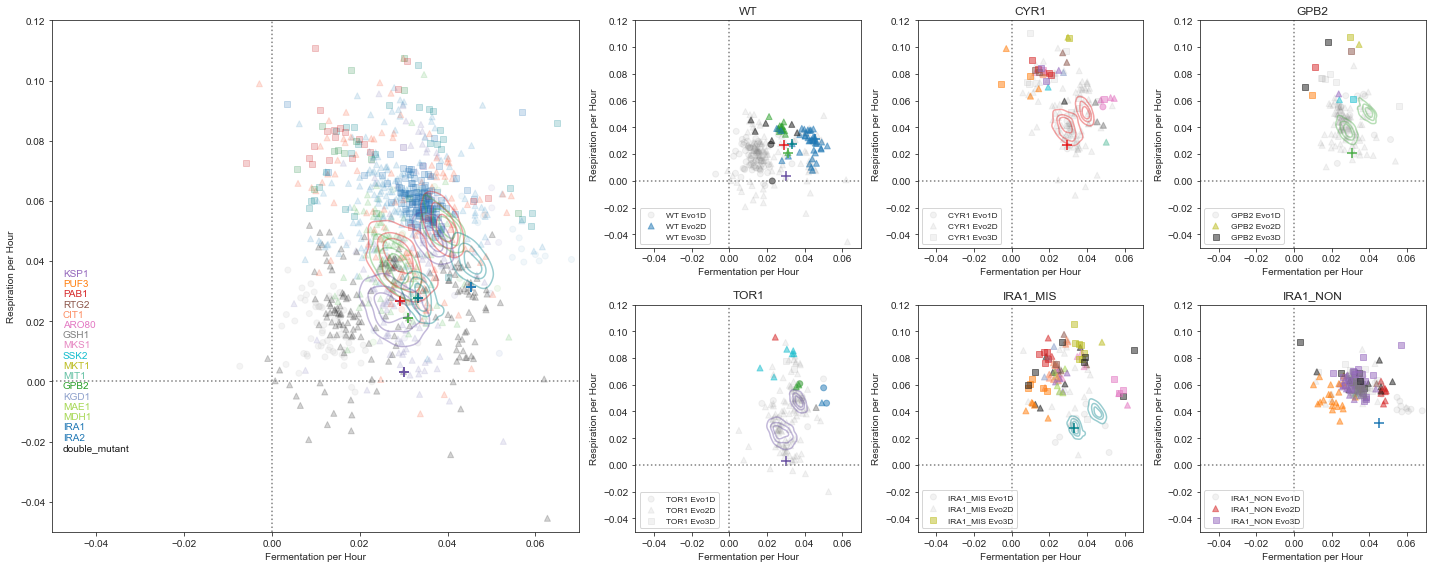

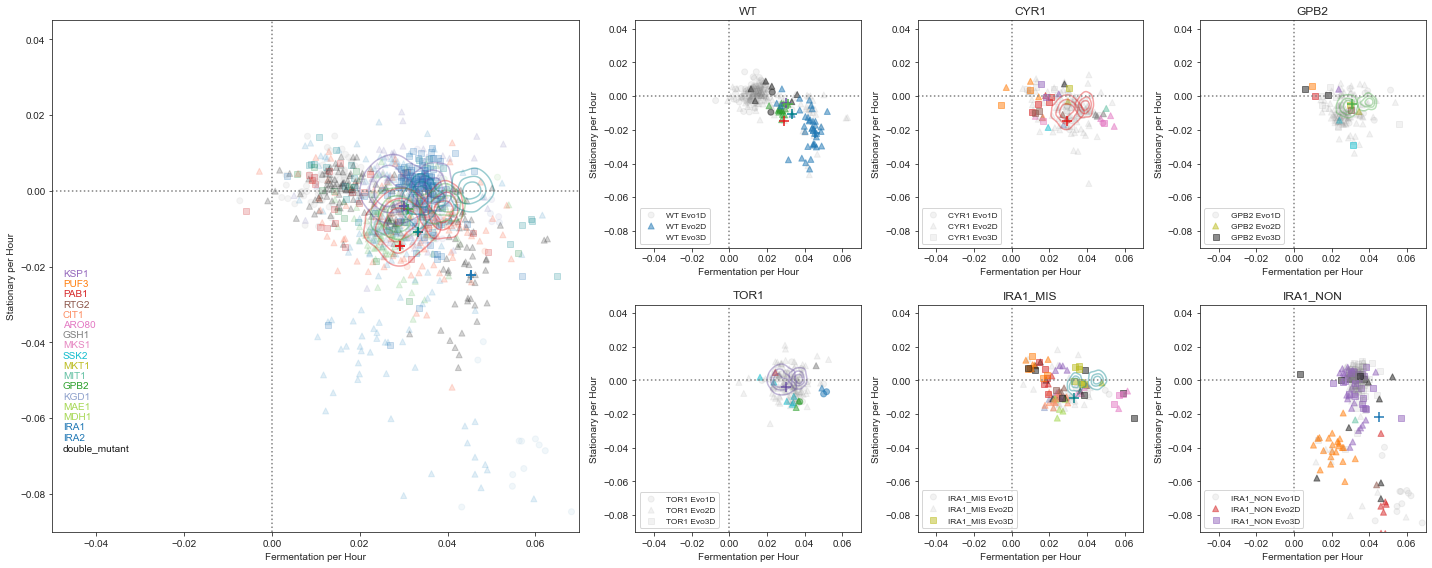

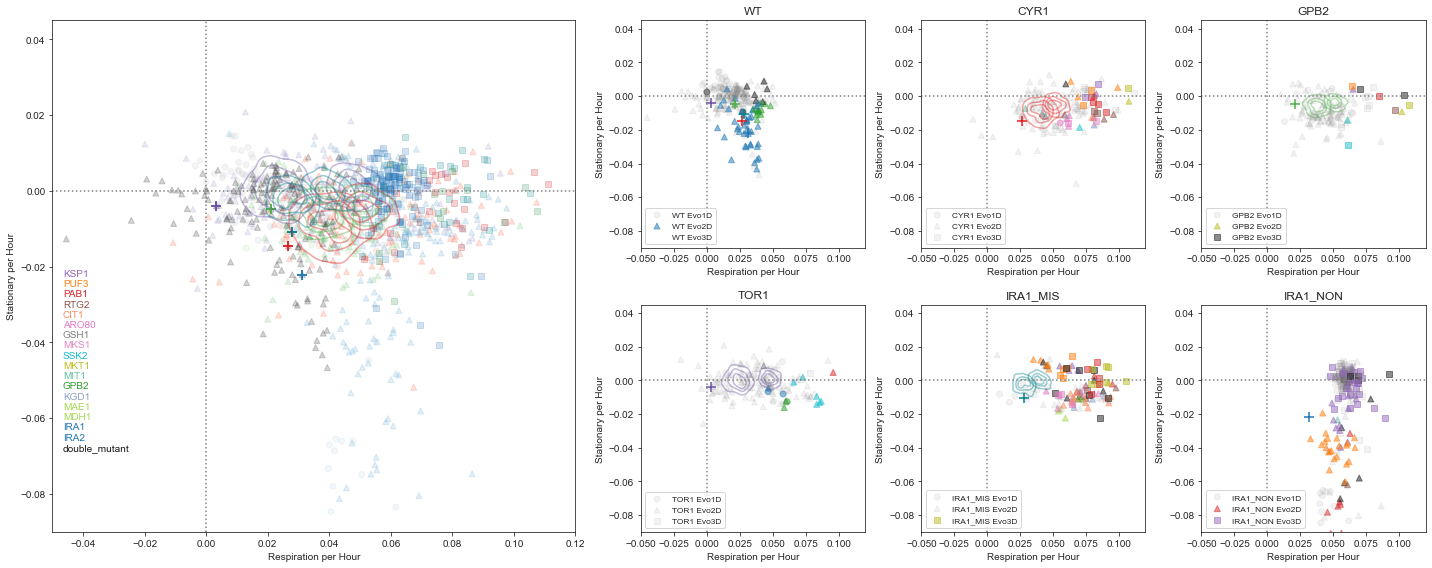

In [32]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}

# evo_cond_list = ['Evo1D']
evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = ['Evo1D','Evo2D','Evo3D']

for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
# publication_list = [['This_study','Li2019','Aggeli2020','Venkataram2015'],['Venkataram2015'],['Li2019'],['Aggeli2020'],['This_study'],['Venkataram2015','This_study']] 
    ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]
    fig = plt.figure(figsize=(20,8))
    outer_gs = gridspec.GridSpec(1, 2,width_ratios=[2,3])

    for a,ancs in enumerate(ancestor_list):
        inner_gs = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)
#         this_anc = non_diploid[non_diploid['ancestor'].isin(ancs)]
        
        this_anc = merged_fitness[merged_fitness['ancestor'].isin(ancs)]
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values
        
        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]

        if len(ancs) > 1:
            fig.add_subplot(outer_gs[0]) 
        else:
            fig.add_subplot(inner_gs[a-1])
            
        for anc in ancs:
            if anc != 'WT':
                this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

                sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

                this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

                sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                            color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

#         for evo_cond in np.unique(this_anc['evolution_condition'].values):
        for evo_cond in evo_cond_list:
            this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
            gray_alpha = 0.1
            bold_alpha = 0.5
            if len(ancs) < 2:
                colors = []
                annotation_list = []
                for e,gene in enumerate(this_data['gene'].values):
                    color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    already_assigned = False
                    if (not p.isnull(gene)) and (gene != 'NotSequenced'):
                        if gene in tools.mutation_color_map.keys():
                            color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map[gene],bold_alpha)
                        elif '+' in gene:
                            color_assigned = matplotlib.colors.to_rgba(tools.mutation_color_map['double_mutant'],bold_alpha)
                            annotation_list.append([e,gene])
                        else:
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    else:
                            color_assigned = matplotlib.colors.to_rgba('gray',0.1)
                    colors.append(color_assigned)
            else:
                colors = [tools.color_map[anc][evo_cond] for anc,evo_cond in zip(this_data['ancestor'],this_data['evolution_condition'])]

            if len(ancs) > 1:
                alpha = 0.2
#                 plt.errorbar(this_data[xdata].values,this_data[ydata].values,
#                             xerr=this_data[xdata+'_error'].values,
#                             yerr=this_data[ydata+'_error'].values,
#                             alpha=alpha,color='k',marker=' ',ls='none')
                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            alpha=alpha,color=colors,marker=tools.evo_cond_marker_map[evo_cond])
               
                
            else:
                alpha = 0.3
                plt.scatter(this_data[xdata].values,this_data[ydata].values,
                            color=colors,marker=tools.evo_cond_marker_map[evo_cond],label=f'{ancs[0]} {evo_cond}')
    
#                 for e,doubles in annotation_list:
#                     plt.annotate(text=doubles,xy=(this_data[xdata].values[e],this_data[ydata].values[e]),
#                                 arrowprops=dict(arrowstyle="-"))

                plt.legend(loc='lower left',fontsize='small')
                plt.title(f'{ancs[0]}')
                
            


#         for anc in ancs:
        for anc in ancs:
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
#                 plt.errorbar(background_mutant[xdata].values,background_mutant[ydata].values,
#                             xerr=background_mutant[xdata+'_error'].values,
#                             yerr=background_mutant[ydata+'_error'].values,
#                             marker=' ',color='k',ls='none')
                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc],s=100)
            else:
                for anc2 in tools.rebarcoding_source_mutants.keys():
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                    plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='+',color=tools.anc_color_map[anc2],s=100)


        plt.xlim(lims[xdata][0],lims[xdata][1])
        plt.ylim(lims[ydata][0],lims[ydata][1])

        plt.xlabel(labels[xdata])
        plt.ylabel(labels[ydata])

#         plt.axvline(0,color='k',linestyle=':')
#         plt.axhline(0,color='k',linestyle=':')
        
        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
        if len(ancs) > 1:
            for g,gene in enumerate(tools.mutation_color_map.keys()):
                plt.text(y=0.5-0.02*g,x=0.02,s=f'{gene}',color=tools.mutation_color_map[gene],transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.savefig(f'{home_dir}/figures/analysis/tradeoffs/tradeoffs_{xdata}_{ydata}_mutation_colors_unannotated.pdf',bbox_inches='tight')




In [37]:
# merged_fitness[(merged_fitness['ancestor'].isin(['IRA1_MIS','IRA1_NON'])) &
#                (merged_fitness['evolution_condition'].isin(['Evo1D'])) &
#               (~merged_fitness['class'].isin(['neutral_haploids','pure_diploids'])) &
#               (~p.isnull(merged_fitness['all_mutations_verbose'])) ][['ancestor','gene','all_mutations_verbose']].values


merged_fitness[(merged_fitness['ancestor'].isin(['IRA1_NON'])) &
               (merged_fitness['evolution_condition'].isin(['Evo1D'])) &
              (~merged_fitness['class'].isin(['neutral_haploids','pure_diploids'])) &
              (~p.isnull(merged_fitness['all_mutations_verbose'])) ][['ancestor','gene','all_mutations_verbose']].values

array([['IRA1_NON', 'PLB3',
        'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~IV:220027:C:T:PPH21:missense_variant:c.745G>A:p.Val249Met:0/1~VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan:1/1~VII:1023358:C:A:YGR266W:missense_variant:c.703C>A:p.Gln235Lys:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1~XV:301306:G:A:PLB3:upstream_gene_variant:c.-4043G>A:nan:0/1'],
       ['IRA1_NON', nan,
        'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan:1/1~VII:1023358:C:A:YGR266W:missense_variant:c.703C>A:p.Gln235Lys:1/1~XII:1029498:C:A:RPL6B:synonymous_variant:c.261C>A:p.Thr87Thr:1/1'],
       ['IRA1_NON', nan,
        'II:522427:A:T:IRA1:stop_gained:c.4202T>A:p.Leu1401*:1/1~VI:60135:G:T:RPO41:missense_variant:c.1354G>T:p.Val452Phe:0/1~VI:101127:T:A:LPD1:downstream_gene_variant:c.*501A>T:nan:1/1~VIII:203418:G:T:AAP1:upstream_gene_variant:c.-2108C>A:nan:0/1~XII:841888:C:A:RSC2:synonymous

In [38]:


merged_fitness[(merged_fitness['gene'].isin(['PUF3+YPK9']))][['ancestor','gene','all_mutations_verbose']].values

array([['IRA1_MIS', 'PUF3+YPK9',
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~XII:122900:AT:A:PUF3:frameshift_variant:c.1814delA:p.Asn605fs:1/1~XV:863077:T:G:YPK9:missense_variant:c.1903T>G:p.Phe635Val:1/1'],
       ['IRA1_MIS', 'PUF3+YPK9',
        'II:522697:G:A:IRA1:missense_variant:c.3932C>T:p.Ala1311Val:1/1~XII:123196:G:A:PUF3:stop_gained:c.1519C>T:p.Gln507*:1/1~XV:87280:AT:A:MDH2:upstream_gene_variant:c.-4361delA:nan:1/1~XV:863524:G:A:YPK9:missense_variant:c.2350G>A:p.Gly784Arg:1/1'],
       ['CYR1', 'PUF3+YPK9',
        'X:427906:C:A:CYR1:NON_SYNONYMOUS_CODING:tCt/tAt:S917Y:1~XII:123802:A:AG:PUF3:FRAME_SHIFT:ccc/cccC:P304P?:1~XV:609456:A:C:SPP2:UPSTREAM:259:nan:1~XV:861934:A:G:YPK9:NON_SYNONYMOUS_CODING:Agt/Ggt:S254G:1~XVI:940751:T:G:ARR3:NON_SYNONYMOUS_CODING:aTt/aGt:I277S:1']],
      dtype=object)